In [1]:
import matplotlib as mpl
import os, sys
mpl.use('Agg')
from LiteNet import *
import tensorflow as tf
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from time import time
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm, trange
np.set_printoptions(precision=3, linewidth=120)

%matplotlib inline

In [2]:
from nystrom_kexpfam.data_generators.Gaussian import GaussianGridWrapped
from nystrom_kexpfam.data_generators.Ring import Ring
from nystrom_kexpfam.data_generators.Dataset import GlassPosteriorDataset

from nystrom_kexpfam.log import logger
from nystrom_kexpfam.visualisation import visualise_array_2d

from nystrom_kexpfam.estimators.KMCLite import KMCLite

INFO: 2018-05-06 15:03:39,437: log.<module>(): Global logger initialised with loglevel 20
INFO: 2018-05-06 15:03:39,637: log.<module>(): Global logger initialised with loglevel 20
/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
ERROR (theano.gpuarray): Could not initialize pygpu, support disabled
Traceback (most recent call last):
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 164, in <module>
    use(config.device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 151, in use
    init_dev(device)
  File "/nfs/nhome/live/kevinli/anaconda/lib/python2.7/site-packages/theano/gpuarray/__init__.py", line 68, in init_dev
    context.cudnn_handl

In [3]:
D = 20
p = Ring(D=D, sigma=0.1
         , N_train=10000, N_test=10000)

#p = GaussianGridWrapped(D=2, sigma=0.1, N_train=10000, N_test=15000)
def gen_data(n):
    
    rand_data = p.sample(n)
    
    return rand_data

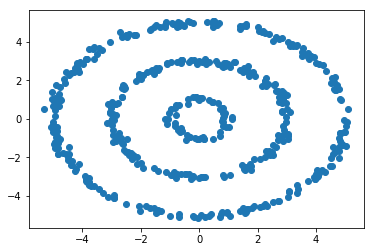

In [4]:
rand_train_data = gen_data(500)
plt.scatter(rand_train_data[:,0],rand_train_data[:,1])
#plt.scatter(rand_points[:,0],rand_points[:,1], alpha=0.5);

In [5]:
net_type = "i"
step_size = 1e-2
init_std = 1e-1
niter = 1000

ndim = (50,)
npoint = 500
batch_size = 500
ntrain = npoint
nval = 500
seed = 1

ngrid = 100
plot_size=12


np.random.seed(1)

sigma = 10**(tf.Variable(0, dtype="float32"))

lam = 10**(tf.Variable(-2, dtype="float32"))
lam2 = 10**(tf.Variable(-2, dtype="float32"))

#lam2 = tf.identity(lam)
lam3= 10**(tf.Variable(-2, dtype="float32"))
'''

sigma = 10**(tf.Variable(-0.28930734309156175, dtype="float32"))
lam = 10**(tf.Variable(-3.7505961659489397, dtype="float32"))

lam2 = tf.identity(lam)
lam3= 10**(tf.constant(-50, dtype="float32"))
'''

'\n\nsigma = 10**(tf.Variable(-0.28930734309156175, dtype="float32"))\nlam = 10**(tf.Variable(-3.7505961659489397, dtype="float32"))\n\nlam2 = tf.identity(lam)\nlam3= 10**(tf.constant(-50, dtype="float32"))\n'

In [6]:
scores = np.zeros(niter+1)
sigmas = np.zeros(niter+1)
lams   = np.zeros(niter+1)
lam2s  = np.zeros(niter+1)
lam3s  = np.zeros(niter+1)

fvs = []

test_data = tf.placeholder("float32", shape=(None, D), name="test_data")
points  = tf.placeholder("float32", shape=(npoint, D), name="points")

rand_val_data = gen_data(nval)
rand_test_data = gen_data(nval)
rand_points = gen_data(npoint)

test_grad_true = p.grad_multiple(rand_test_data)

if D == 2:
    eval_points = np.array([[xv,yv] 
            for xv in np.linspace(-plot_size/2,plot_size/2,ngrid) 
                            for yv in np.linspace(-plot_size/2,plot_size/2,ngrid)])

In [ ]:
## print '=====building kernel'
kernel  = GaussianKernel(sigma)
kn = KernelModel(kernel)
kn.alpha = tf.Variable(np.zeros(npoint, dtype="float32"))
    
kn.set_points(points)

loss, score, train_data, val_data, r_norm, l_norm, curve, alpha_assign = \
    kn.val_score(lam=lam, lam2=lam2, lam3=lam3)

fv = kn.evaluate_fun(test_data)
gv = kn.evaluate_grad(test_data)

feed   = {train_data: rand_train_data,
          val_data  : rand_val_data,
          test_data : rand_test_data}
feed[points] = feed[train_data]

In [8]:
#optimizer = tf.train.GradientDescentOptimizer(step_size)
#optimizer = tf.train.MomentumOptimizer(step_size, momentum=0.9)
optimizer = tf.train.AdamOptimizer(step_size)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1000)
train_step = optimizer.apply_gradients(zip(gradients, variables))

config = tf.ConfigProto(device_count={"GPU":1})
config.gpu_options.allow_growth=True
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()
sess.run(init)

In [487]:
t0 = time()

for i in range(niter+1):

    if i% 20 == 0:
        feed[val_data] = gen_data(nval)
    
    
    feed[train_data] = gen_data(ntrain)
    feed[val_data] = gen_data(nval)

    feed[points] = feed[train_data]
    


    if i % (niter/5) == 0 and D == 2:

        fv_val = sess.run(fv, feed_dict={train_data:feed[train_data], 
                                         test_data:eval_points,
                                         points: feed[points]})
        fv_val -= fv_val.mean()
        fv_val = np.exp(fv_val)
        fv_val /= np.sum(fv_val)
        fvs.append(fv_val) 


    train_step.run(feed_dict=feed)
    scores[i], r_norm_val, l_norm_val, curve_val, alpha_val = sess.run([score, r_norm, l_norm, 
                                                                        curve, kn.alpha], 
        feed_dict=feed)

    sigmas[i], lams[i], lam2s[i] ,lam3s[i]  = sess.run([sigma, lam, lam2, lam3])

    if i % min(100, niter/5) == 0:
        gv_val = gv.eval(feed)
        print '=================='
        
        print 'Iteration %5d, score %5.3g (%5.3g), time taken %.2f' % (i, scores[i], -D/4.0, time()-t0)
        print 'true score', 0.5*np.mean(np.sum((test_grad_true - gv_val)**2,1))
        print 'sigma: %.5f' % sigma.eval()
        print 'lam, lam2, lam3', lam.eval(), lam2.eval(), lam3.eval()
        print 'alpha: %.5g' % alpha_val.mean()
        print 'rn, ln, c = ', r_norm_val, l_norm_val, curve_val


Iteration     0, score  -446 (   -5), time taken 2.87
true score 506.768583594
sigma: 0.97724
lam, lam2, lam3 0.00977237 0.00977237 0.00977237
alpha: 1.3762
rn, ln, c =  20446.2 1425.16 15818.8
Iteration   100, score  -852 (   -5), time taken 21.18
true score 90.329945843
sigma: 0.31841
lam, lam2, lam3 0.00249211 0.0023315 0.00179251
alpha: 4.162
rn, ln, c =  63845.3 12618.1 135826.0
Iteration   200, score  -858 (   -5), time taken 36.88
true score 93.1289512521
sigma: 0.41328
lam, lam2, lam3 0.00180971 0.00242609 0.0011927
alpha: 4.2008
rn, ln, c =  83705.8 14510.3 144468.0
Iteration   300, score  -852 (   -5), time taken 52.62
true score 81.7541050727
sigma: 0.45785
lam, lam2, lam3 0.00145091 0.00246569 0.000959504
alpha: 4.3162
rn, ln, c =  96909.1 14601.3 151571.0
Iteration   400, score  -882 (   -5), time taken 68.45
true score 79.2514249071
sigma: 0.47473
lam, lam2, lam3 0.00128384 0.00271423 0.000857748
alpha: 4.3764
rn, ln, c =  102527.0 15725.9 157085.0
Iteration   500, score 

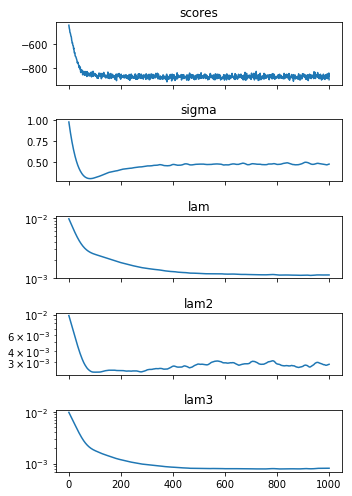

In [488]:

fig, axes = plt.subplots(5,1,figsize=(5,7), sharex=True)
ax = axes[0]
ax.plot(scores)
ax.set_title("scores")
ax = axes[1]
ax.plot(sigmas)
ax.set_title("sigma")
ax = axes[2]
ax.plot(lams)
ax.set_title("lam")
ax.set_yscale("log")
ax = axes[3]
ax.plot(lam2s)
ax.set_title("lam2")
ax.set_yscale("log")
ax = axes[4]
ax.plot(lam3s)
ax.set_title("lam3")
ax.set_yscale("log")

fig.tight_layout()
#fig.savefig("figs/grid_dist/test_hist.pdf") 

In [489]:
np.random.seed(1)

cv_scores=[]
gs_scores=[]

for i in range(20):
    print "=== test %d ===" % i
    batch_size = 500
    rand_train_data = gen_data(batch_size)
    rand_test_data = gen_data(batch_size*10)

    cv_ge = []
    sc = []
    for i in range(rand_test_data.shape[0]/batch_size):
        d = rand_test_data[i*batch_size:(i+1)*batch_size]
        o1, o2 = sess.run([gv, score], feed_dict={train_data: rand_train_data, 
                                                  test_data: d, 
                                                  points:rand_train_data,
                                                  val_data: d})
        cv_ge += [o1]
        sc += [o2]

    cv_ge = np.concatenate(cv_ge,0)
    gt = p.grad_multiple(rand_test_data)
    cv_score = 0.5*np.mean(np.sum((cv_ge-gt)**2,1))
    print "cv model score: ", np.mean(sc)
    print "cv true score:  ", cv_score

    
    
    if D == 2:
        est = KMCLite(m = 500, sigma = np.exp(0.1224), lmbda = np.exp(-4.1224))
    elif D == 4:
        est = KMCLite(m = 500, sigma = np.exp(-0.0612), lmbda = np.exp(-2.8980))
    elif D == 6:
        est = KMCLite(m = 500, sigma = np.exp(-0.0612), lmbda = np.exp(-2.4082))
    elif D == 8:
        est = KMCLite(m = 500, sigma = np.exp(-0.0612), lmbda = np.exp(-1.9184))
    elif D == 10:
        est = KMCLite(m = 500, sigma = np.exp(-0.0612), lmbda = np.exp(-1.9184))



    est.fit(rand_train_data)

    gs_ge = est.grad(rand_test_data)

    sc = []
    for i in range(rand_test_data.shape[0]/batch_size):
        d = rand_test_data[i*batch_size:(i+1)*batch_size]
        sc += [est.score(d)]
        
    gs_score = 0.5*np.mean(np.sum((gs_ge-gt)**2,1))
    print "gs model score: ", np.mean(sc)
    print "gs true score:  ", gs_score
    #plt.scatter(gt.flatten(), ge.flatten(), 5, marker='x');
    #plt.scatter(gt.flatten(), ge_kn.flatten(), 5, marker='o');
    #plt.legend(["gs","cv"])
    #plt.plot([-40,40],[-40,40])
    cv_scores.append(cv_score)
    gs_scores.append(gs_score)

=== test 0 ===
cv model score:  -880.932
cv true score:   77.0206537508
gs model score:  -876.140170041
gs true score:   82.7146414161
=== test 1 ===
cv model score:  -873.853
cv true score:   80.7486860184
gs model score:  -864.243726087
gs true score:   90.8086083481
=== test 2 ===
cv model score:  -865.082
cv true score:   86.8479866741
gs model score:  -856.307124506
gs true score:   95.6144507952
=== test 3 ===
cv model score:  -868.057
cv true score:   83.3904001915
gs model score:  -863.320643955
gs true score:   87.8611641756
=== test 4 ===
cv model score:  -869.487
cv true score:   88.8549789557
gs model score:  -861.421247104
gs true score:   97.8755103906
=== test 5 ===
cv model score:  -866.254
cv true score:   83.381616543
gs model score:  -857.197030852
gs true score:   92.038983668
=== test 6 ===
cv model score:  -868.317
cv true score:   83.3242273992
gs model score:  -862.130862785
gs true score:   88.8675351301
=== test 7 ===
cv model score:  -870.191
cv true score:  

In [478]:
np.mean(np.array(gs_scores) - np.array(cv_scores))

0.42033573252577805

In [479]:
ttest_rel(cv_scores, gs_scores)

Ttest_relResult(statistic=-5.2591274366987069, pvalue=4.471391934482587e-05)

MannwhitneyuResult(statistic=12404863.0, pvalue=0.25491832931691616)


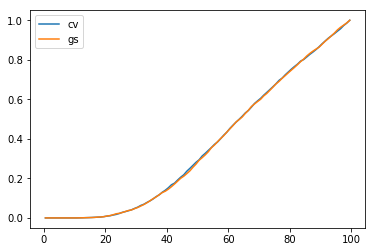

In [480]:

def plot_error_cdf(data, bins = 10, ax = None):
    if ax is None:
        _, ax = plt.subplots()
    counts, _ = np.histogram(data, bins=bins, normed=True)
    centers = 0.5*(bins[1:]+bins[:-1])
    cdf    = np.cumsum(counts)
    ax.plot(centers, cdf)
    
fig, ax = plt.subplots()
bins = np.linspace(0,100,101)

gs_errors = np.sum((gs_ge-gt)**2,1)
cv_errors = np.sum((cv_ge-gt)**2,1)

plot_error_cdf(cv_errors, bins = bins, ax=ax)
plot_error_cdf(gs_errors, bins = bins, ax=ax)
plt.legend(["cv","gs"])
a = wilcoxon(cv_errors, gs_errors)
print mannwhitneyu(cv_errors, gs_errors)

In [437]:
"results/param_search/Ring_D%d_rep50_res40.h5" % 4

'results/param_search/Ring_D4_rep50_res40.h5'

In [449]:
import h5py as h5 
with h5.File("results/param_search/Ring_D%d_rep50_res40.h5" % 4,"r") as f:
    print f.keys()
    grid_scores = f["scores"].value
    if "all_scores" in f.keys():
        grid_all_scores = f["all_scores"].value
    Y = f["lams"].value
    X = f["sigs"].value

[u'lams', u'scores', u'sigs']


In [450]:
Y

array([-6.   , -5.897, -5.795, -5.692, -5.59 , -5.487, -5.385, -5.282, -5.179, -5.077, -4.974, -4.872, -4.769, -4.667,
       -4.564, -4.462, -4.359, -4.256, -4.154, -4.051, -3.949, -3.846, -3.744, -3.641, -3.538, -3.436, -3.333, -3.231,
       -3.128, -3.026, -2.923, -2.821, -2.718, -2.615, -2.513, -2.41 , -2.308, -2.205, -2.103, -2.   ], dtype=float32)

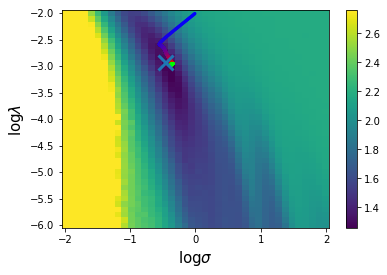

In [451]:
fig, ax = plt.subplots()
#X = np.linspace(-2,3,50, dtype="float32")
#Y = np.linspace(-7,-2,50, dtype="float32")

dX = X[1]-X[0]
dY = Y[1]-Y[0]

def linedge(grid):
    d = grid[2]-grid[1]
    return np.r_[grid-d/2, grid[-1]+d/2]

min_score = np.log10(grid_scores).min()
m = ax.pcolor(linedge(X), linedge(Y), np.log10(grid_scores).T, vmin = min_score, vmax=min_score+1.5)
plt.colorbar(m)
cm = plt.get_cmap("brg")

log_sigams = np.log10(sigmas)
log_lambdas = np.log10(lam2s)

#ax.plot(log_sigams,log_lambdas,zorder=3, marker='.', lw=2);
traj_idx = np.arange(0,5*niter/5,1)
colors = cm(np.linspace(0,1, len(traj_idx)))

ax.scatter(log_sigams[traj_idx],log_lambdas[traj_idx],  np.ones(len(traj_idx))*5, colors,
           marker="o", zorder=2);
#ax.plot(log_sigams[0], log_lambdas[0], "x", ms=10, c="b")

#ax.plot(log_sigams[-1], log_lambdas[-1], "^", ms=10, mew=2,c="g", alpha=0.8)

best_ind = np.unravel_index(np.nanargmin(grid_scores), grid_scores.shape)
plt.plot(X[best_ind[0]], Y[best_ind[1]], 'x', markersize=15, mew=3)


#plt.xlim([-1,0])
#plt.ylim([-4.5,-3])
plt.xlabel(r"$\log\sigma$", fontsize=15)
plt.ylabel(r"$\log\lambda$", fontsize=15)

In [452]:
best_ind

(15, 30)

MannwhitneyuResult(statistic=2321.0, pvalue=2.9823998925796653e-11)

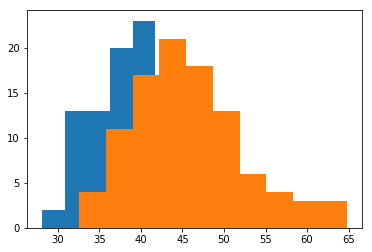

In [453]:
from scipy.stats import mannwhitneyu, wilcoxon


ind = tuple(best_ind+np.array([0,-2]))
plt.hist(grid_all_scores[best_ind])
plt.hist(grid_all_scores[ind])
mannwhitneyu(grid_all_scores[best_ind],grid_all_scores[ind])

(-4.5, -3.5)

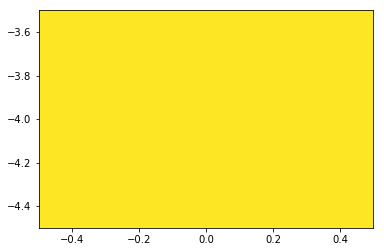

In [454]:
plt.pcolormesh(linedge(X), linedge(Y), np.log10(grid_scores).T, vmin=np.log10(7.5),vmax=np.log10(8.2))
plt.scatter(log_sigams[traj_idx],log_lambdas[traj_idx],  np.ones(len(traj_idx))*5, colors,
           marker="o", zorder=2, alpha=0.5);

plt.xlim([-0.5,0.5])
plt.ylim([-4.5,-3.5])

In [455]:
X[best_ind[0]], Y[best_ind[1]]

(-0.46153846, -2.9230769)

In [456]:

nfvs  = len(fvs)
fig, axes = plt.subplots(3, nfvs,figsize=(15,8), sharex=True, sharey=True)
rand_data = (ngrid/2)+(rand_train_data*ngrid/plot_size)
vmin = min(map(np.min, fvs))
vmax = max(map(np.max, fvs))

for i in range(len(fvs)):

    iter_number = niter/5*i
    ax = axes[0, i]

    hist = (fvs[i])

    ax.imshow( hist.reshape(ngrid, ngrid).T)
    ax.set_title("it=%d, sc=%.3f" % (iter_number, scores[iter_number]))
    ax.set_axis_off()

    ax = axes[1, i]
    ax.imshow( np.log(hist).reshape(ngrid, ngrid).T)
    ax.set_axis_off()


    ax = axes[2, i]
    ax.scatter(rand_data[:,0], rand_data[:,1], 1, "k", alpha=1)
    ax.set_axis_off()


#plt.show()
#fig.savefig("figs/grid_dist/2d_dist_nt%s_np%d_s%02d.pdf" % (net_type, npoint, seed))
#fig.savefig("figs/grid_dist/test.pdf") 


IndexError: index out of range